# Demo Data Pre-processing

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cassandra
import pyspark
import re
import os
import random
from random import randint, randrange
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import PCA, Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, asc
from pyspark.sql.functions import isnan
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

#### Helper function to have nicer formatting of Spark DataFrames

In [4]:
#Helper for pretty formatting for Spark DataFrames
def showDF(df, limitRows =  5, truncate = True):
    if(truncate):
        pd.set_option('display.max_colwidth', 50)
    else:
        pd.set_option('display.max_colwidth', -1)
    pd.set_option('display.max_rows', limitRows)
    display(df.limit(limitRows).toPandas())
    pd.reset_option('display.max_rows')

In [5]:
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<img src="images/dselogo.png" width="400" height="200">

## Creating Tables and Loading Tables

### Connect to Cassandra

In [7]:
from cassandra.cluster import Cluster

cluster = Cluster(['dse'])
session = cluster.connect()

### Create Demo Keyspace 

In [8]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS accelerate 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

### Set keyspace 

In [9]:
session.set_keyspace('accelerate')

### Create table called `socialMedia`. Our PRIMARY will be a unique key (status_id) we generate for each row. 

In [10]:
query = "CREATE TABLE IF NOT EXISTS iris \
                                   (Id int, SepalLengthCm float, SepalWidthCm float, \
                                   PetalLengthCm float, PetalWidthCm float, Species text, \
                                   PRIMARY KEY (Id))"
session.execute(query)

### Load dataset from CSV file

#### Insert all the Data into the Apache Cassandra table `iris`

In [11]:
fileName = 'data/datasets_19_420_Iris.csv'
input_file = open(fileName, 'r')
next(input_file)
for line in input_file:
    row = line.split(',')

    query = "INSERT INTO iris (Id, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s)"
    session.execute(query, (int(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), str(row[5])))
    

## Loading with Apache Spark
<img src="images/sparklogo.png" width="150" height="200">

In [12]:
spark = SparkSession.builder.appName('demo').master("local").getOrCreate()


irisDF = spark.read.format("org.apache.spark.sql.cassandra").options(table="iris", keyspace="accelerate").load()

print ("Table Row Count: ")
print (irisDF.count())

Table Row Count: 
150


In [13]:
showDF(irisDF)

,id,petallengthcm,petalwidthcm,sepallengthcm,sepalwidthcm,species
0,23,1.000000000000000000,0.200000000000000000,4.600000000000000000,3.600000000000000000,Iris-setosa\n
1,114,5.000000000000000000,2.000000000000000000,5.700000000000000000,2.500000000000000000,Iris-virginica\n
2,53,4.900000000000000000,1.500000000000000000,6.900000000000000000,3.100000000000000000,Iris-versicolor\n
3,110,6.100000000000000000,2.500000000000000000,7.200000000000000000,3.600000000000000000,Iris-virginica\n
4,91,4.400000000000000000,1.200000000000000000,5.500000000000000000,2.600000000000000000,Iris-versicolor\n


In [14]:
labelIndexer = StringIndexer(inputCol="species", outputCol="label", handleInvalid='keep')
training = labelIndexer.fit(irisDF).transform(irisDF)

showDF(training)

,id,petallengthcm,petalwidthcm,sepallengthcm,sepalwidthcm,species,label
0,23,1.000000000000000000,0.200000000000000000,4.600000000000000000,3.600000000000000000,Iris-setosa\n,1.0
1,114,5.000000000000000000,2.000000000000000000,5.700000000000000000,2.500000000000000000,Iris-virginica\n,0.0
2,53,4.900000000000000000,1.500000000000000000,6.900000000000000000,3.100000000000000000,Iris-versicolor\n,2.0
3,110,6.100000000000000000,2.500000000000000000,7.200000000000000000,3.600000000000000000,Iris-virginica\n,0.0
4,91,4.400000000000000000,1.200000000000000000,5.500000000000000000,2.600000000000000000,Iris-versicolor\n,2.0


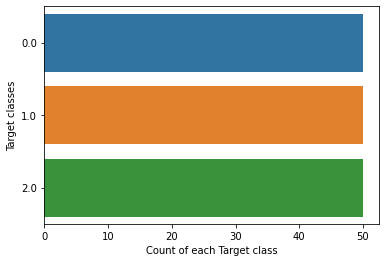

In [15]:
irisPD = training.toPandas()
sns.countplot(y=irisPD.label)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

In [16]:
assembler = VectorAssembler(
    inputCols=['petallengthcm', 'sepalwidthcm', 'petalwidthcm', 'sepallengthcm'],
    outputCol='features')

trainingData = assembler.transform(training)

In [17]:
splits = trainingData.randomSplit([0.8, 0.2], 124)
train = splits[0]
test = splits[1]

print ("Train Dataframe Row Count: ")
print (train.count())
print ("Test Datafram Row Count: ")
print (test.count())

Train Dataframe Row Count: 
120
Test Datafram Row Count: 
30


In [18]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

model = rf.fit(train)

predictions = model.transform(test)
#predictions.show()
showDF(predictions)

,id,petallengthcm,petalwidthcm,sepallengthcm,sepalwidthcm,species,label,features,rawPrediction,probability,prediction
0,13,1.400000000000000000,0.100000000000000000,4.800000000000000000,3.000000000000000000,Iris-setosa\n,1.0,"[1.4, 3.0, 0.1, 4.8]","[0.0, 10.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]",1.0
1,19,1.700000000000000000,0.300000000000000000,5.700000000000000000,3.800000000000000000,Iris-setosa\n,1.0,"[1.7, 3.8, 0.3, 5.7]","[0.0, 10.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]",1.0
2,23,1.000000000000000000,0.200000000000000000,4.600000000000000000,3.600000000000000000,Iris-setosa\n,1.0,"[1.0, 3.6, 0.2, 4.6]","[0.0, 10.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]",1.0
3,46,1.400000000000000000,0.300000000000000000,4.800000000000000000,3.000000000000000000,Iris-setosa\n,1.0,"[1.4, 3.0, 0.3, 4.8]","[0.0, 10.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]",1.0
4,52,4.500000000000000000,1.500000000000000000,6.400000000000000000,3.200000000000000000,Iris-versicolor\n,2.0,"[4.5, 3.2, 1.5, 6.4]","[0.7142857142857143, 0.0, 9.285714285714285, 0.0]","[0.07142857142857144, 0.0, 0.9285714285714286,...",2.0


In [19]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.9666666666666667


In [21]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="f1")
f1 = evaluator.evaluate(predictions)
print("Test set f1 score = " + str(f1))

Test set f1 score = 0.9666666666666668


In [22]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
print(class_temp)
class_names = ["Iris-virginica" if x==0.0 else x for x in class_temp]
class_names = ["Iris-setosa" if x==1.0 else x for x in class_names]
class_names = ["Iris-versicolor" if x==2.0 else x for x in class_names]
print(class_names)

[1.0, 2.0, 0.0]
['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


In [23]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[11,  0,  0],
       [ 0,  9,  1],
       [ 0,  0,  9]])

Confusion matrix, without normalization
[[11  0  0]
 [ 0  9  1]
 [ 0  0  9]]


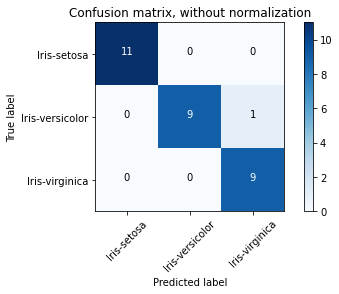

In [24]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [25]:
query = "CREATE TABLE IF NOT EXISTS diabetes \
                                   (Id int, timesPregnant int, plasmaGlucose int, bloodPressure int, \
                                   tricepThickness int, serumInsulin int, bmi float, diabetesPedegree float, \
                                   age int, label int, PRIMARY KEY (Id))"
session.execute(query)

In [26]:
fileName = 'data/pima-indians-diabetes.csv'
input_file = open(fileName, 'r')
i = 1
for line in input_file:
    iD = i
    row = line.split(',')

    query = "INSERT INTO diabetes (Id, timesPregnant, plasmaGlucose, bloodPressure, \
                                   tricepThickness, serumInsulin, bmi, diabetesPedegree, \
                                   age, label)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (int(iD), int(row[0]), int(row[1]), int(row[2]), int(row[3]), int(row[4]), float(row[5]), float(row[6]), int(row[7]), int(row[8])))
    i = i + 1

In [27]:
diabetesDF = spark.read.format("org.apache.spark.sql.cassandra").options(table="diabetes", keyspace="accelerate").load()

print ("Table Row Count: ")
print (diabetesDF.count())

Table Row Count: 
768


In [28]:
showDF(diabetesDF, 20)

,id,age,bloodpressure,bmi,diabetespedegree,label,plasmaglucose,seruminsulin,timespregnant,tricepthickness
0,23,41,90,39.799999,0.451,1,196,0,7,0
1,114,25,62,34.000000,0.391,0,76,0,4,0
2,660,27,82,34.200001,1.292,1,80,70,3,31
3,53,30,66,24.400000,0.342,0,88,23,5,21
4,110,24,85,37.400002,0.247,1,95,36,0,25
5,91,21,55,19.100000,0.258,0,80,0,1,0
6,128,23,58,33.299999,0.261,0,118,94,1,36
7,363,65,108,39.200001,0.305,0,103,0,5,37
8,251,42,52,31.200001,0.380,0,106,0,9,0
9,744,45,94,32.700001,0.734,1,140,0,9,0


In [29]:
print(diabetesDF.schema.names)
print([diabetesDF.where((col(c_name) == 0)).count() for c_name in diabetesDF.schema.names])

['id', 'age', 'bloodpressure', 'bmi', 'diabetespedegree', 'label', 'plasmaglucose', 'seruminsulin', 'timespregnant', 'tricepthickness']
[0, 0, 35, 11, 0, 500, 5, 374, 111, 227]


In [30]:
diabetesDF = diabetesDF.withColumn("bloodpressure", F.when(F.col("bloodpressure")==0, float("nan")).otherwise(F.col("bloodpressure")))
diabetesDF = diabetesDF.withColumn("plasmaglucose", F.when(F.col("plasmaglucose")==0, float("nan")).otherwise(F.col("plasmaglucose")))
diabetesDF = diabetesDF.withColumn("tricepthickness", F.when(F.col("tricepthickness")==0, float("nan")).otherwise(F.col("tricepthickness")))
diabetesDF = diabetesDF.withColumn("seruminsulin", F.when(F.col("seruminsulin")==0, float("nan")).otherwise(F.col("seruminsulin")))
diabetesDF = diabetesDF.withColumn("bmi", F.when(F.col("bmi")==0, float("nan")).otherwise(F.col("bmi")))

In [31]:
print(diabetesDF.schema.names)
print([diabetesDF.where((col(c_name) == 0)).count() for c_name in diabetesDF.schema.names])

['id', 'age', 'bloodpressure', 'bmi', 'diabetespedegree', 'label', 'plasmaglucose', 'seruminsulin', 'timespregnant', 'tricepthickness']
[0, 0, 0, 0, 0, 500, 0, 0, 111, 0]


In [32]:
showDF(diabetesDF, 20)

,id,age,bloodpressure,bmi,diabetespedegree,label,plasmaglucose,seruminsulin,timespregnant,tricepthickness
0,23,41,90.0,39.799999,0.451,1,196.0,NaN,7,NaN
1,114,25,62.0,34.000000,0.391,0,76.0,NaN,4,NaN
2,660,27,82.0,34.200001,1.292,1,80.0,70.0,3,31.0
3,53,30,66.0,24.400000,0.342,0,88.0,23.0,5,21.0
4,110,24,85.0,37.400002,0.247,1,95.0,36.0,0,25.0
5,91,21,55.0,19.100000,0.258,0,80.0,NaN,1,NaN
6,128,23,58.0,33.299999,0.261,0,118.0,94.0,1,36.0
7,363,65,108.0,39.200001,0.305,0,103.0,NaN,5,37.0
8,251,42,52.0,31.200001,0.380,0,106.0,NaN,9,NaN
9,744,45,94.0,32.700001,0.734,1,140.0,NaN,9,NaN


In [33]:
imputer = Imputer()
imputer.setInputCols(["plasmaglucose", "bloodpressure", "bmi"])
imputer.setOutputCols(["out_plasmaglucose", "out_bloodpressure", "out_bmi"])
model = imputer.fit(diabetesDF)
#model.setInputCols(["plasmaglucose", "bloodpressure", "bmi"])
training = model.transform(diabetesDF)
showDF(training,100)

,id,age,bloodpressure,bmi,diabetespedegree,label,plasmaglucose,seruminsulin,timespregnant,tricepthickness,out_plasmaglucose,out_bloodpressure,out_bmi
0,23,41,90.0,39.799999,0.451,1,196.0,NaN,7,NaN,196.0,90.000000,39.799999
1,114,25,62.0,34.000000,0.391,0,76.0,NaN,4,NaN,76.0,62.000000,34.000000
2,660,27,82.0,34.200001,1.292,1,80.0,70.0,3,31.0,80.0,82.000000,34.200001
3,53,30,66.0,24.400000,0.342,0,88.0,23.0,5,21.0,88.0,66.000000,24.400000
4,110,24,85.0,37.400002,0.247,1,95.0,36.0,0,25.0,95.0,85.000000,37.400002
5,91,21,55.0,19.100000,0.258,0,80.0,NaN,1,NaN,80.0,55.000000,19.100000
6,128,23,58.0,33.299999,0.261,0,118.0,94.0,1,36.0,118.0,58.000000,33.299999
7,363,65,108.0,39.200001,0.305,0,103.0,NaN,5,37.0,103.0,108.000000,39.200001
8,251,42,52.0,31.200001,0.380,0,106.0,NaN,9,NaN,106.0,52.000000,31.200001
9,744,45,94.0,32.700001,0.734,1,140.0,NaN,9,NaN,140.0,94.000000,32.700001


In [34]:
assembler = VectorAssembler(
    inputCols=['age', 'out_bloodpressure', 'out_bmi', 'diabetespedegree', 'out_plasmaglucose', 'seruminsulin', 'timespregnant', 'tricepthickness'],
    outputCol='features', handleInvalid = "keep")

trainingData = assembler.transform(training)
showDF(trainingData)

,id,age,bloodpressure,bmi,diabetespedegree,label,plasmaglucose,seruminsulin,timespregnant,tricepthickness,out_plasmaglucose,out_bloodpressure,out_bmi,features
0,23,41,90.0,39.799999,0.451,1,196.0,NaN,7,NaN,196.0,90.0,39.799999,"[41.0, 90.0, 39.79999923706055, 0.451000005006..."
1,114,25,62.0,34.000000,0.391,0,76.0,NaN,4,NaN,76.0,62.0,34.000000,"[25.0, 62.0, 34.0, 0.39100000262260437, 76.0, ..."
2,660,27,82.0,34.200001,1.292,1,80.0,70.0,3,31.0,80.0,82.0,34.200001,"[27.0, 82.0, 34.20000076293945, 1.292000055313..."
3,53,30,66.0,24.400000,0.342,0,88.0,23.0,5,21.0,88.0,66.0,24.400000,"[30.0, 66.0, 24.399999618530273, 0.34200000762..."
4,110,24,85.0,37.400002,0.247,1,95.0,36.0,0,25.0,95.0,85.0,37.400002,"[24.0, 85.0, 37.400001525878906, 0.24699999392..."


In [35]:
splits = trainingData.randomSplit([0.8, 0.2], 124)
train = splits[0]
test = splits[1]

print ("Train Dataframe Row Count: ")
print (train.count())
print ("Test Datafram Row Count: ")
print (test.count())

Train Dataframe Row Count: 
621
Test Datafram Row Count: 
147


In [36]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

model = rf.fit(train)

predictions = model.transform(test)
#predictions.show()
showDF(predictions)

,id,age,bloodpressure,bmi,diabetespedegree,label,plasmaglucose,seruminsulin,timespregnant,tricepthickness,out_plasmaglucose,out_bloodpressure,out_bmi,features,rawPrediction,probability,prediction
0,13,57,80.0,27.100000,1.441,0,139.0,NaN,10,NaN,139.0,80.0,27.100000,"[57.0, 80.0, 27.100000381469727, 1.44099998474...","[5.6437422000907125, 4.3562577999092875]","[0.5643742200090712, 0.4356257799909288]",0.0
1,19,33,30.0,43.299999,0.183,0,103.0,83.0,1,38.0,103.0,30.0,43.299999,"[33.0, 30.0, 43.29999923706055, 0.182999998331...","[7.667466237783535, 2.3325337622164635]","[0.7667466237783537, 0.23325337622164638]",0.0
2,23,41,90.0,39.799999,0.451,1,196.0,NaN,7,NaN,196.0,90.0,39.799999,"[41.0, 90.0, 39.79999923706055, 0.451000005006...","[1.8740507633145942, 8.125949236685406]","[0.18740507633145942, 0.8125949236685406]",1.0
3,46,25,66.0,42.000000,1.893,1,180.0,NaN,0,39.0,180.0,66.0,42.000000,"[25.0, 66.0, 42.0, 1.8930000066757202, 180.0, ...","[2.799021562417932, 7.2009784375820685]","[0.2799021562417932, 0.7200978437582068]",1.0
4,52,26,50.0,24.200001,0.526,0,101.0,36.0,1,15.0,101.0,50.0,24.200001,"[26.0, 50.0, 24.200000762939453, 0.52600002288...","[8.655483676674187, 1.3445163233258135]","[0.8655483676674187, 0.13445163233258134]",0.0


In [38]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
print(class_temp)
class_names = ["Negative" if x==0.0 else x for x in class_temp]
class_names = ["Positive" if x==1.0 else x for x in class_names]
print(class_names)

[0, 1]
['Negative', 'Positive']


In [39]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[90,  7],
       [23, 27]])

Confusion matrix, without normalization
[[90  7]
 [23 27]]


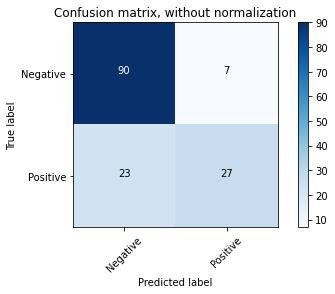

In [40]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [54]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.7959183673469388


In [56]:
tp = cnf_matrix[0][0]
tn = cnf_matrix[1][1]
fn = cnf_matrix[1][0]
fp = cnf_matrix[0][1]
accuracy = (tp+tn)/(tp+tn+fn+fp)
print("Test set accuracy = " + str(accuracy))

recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1 = (2*recall*precision)/(recall + precision)
print("Test set F1 score = " + str(f1))

Test set accuracy = 0.7959183673469388
Test set F1 score = 0.8571428571428572
